# Toy example

In [151]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import seaborn as sns
from scipy.special import expit
import pandas as pd
from tqdm import tqdm
np.random.seed(42)

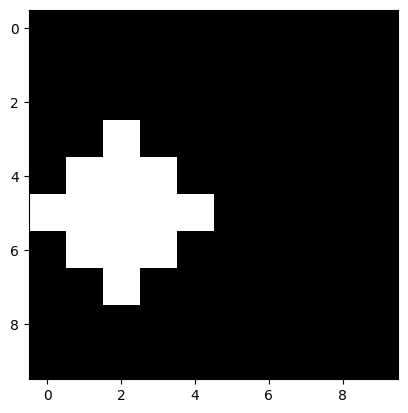

In [2]:
def generate_image(r, x, y, size=10):
    img = np.zeros((size, size), dtype=np.uint8)
    c = (int(x), int(y))
    cv2.circle(img, c, int(r), 255, -1)
    return img

plt.imshow(generate_image(2, 2, 5, size=10),cmap='gray')
plt.show()

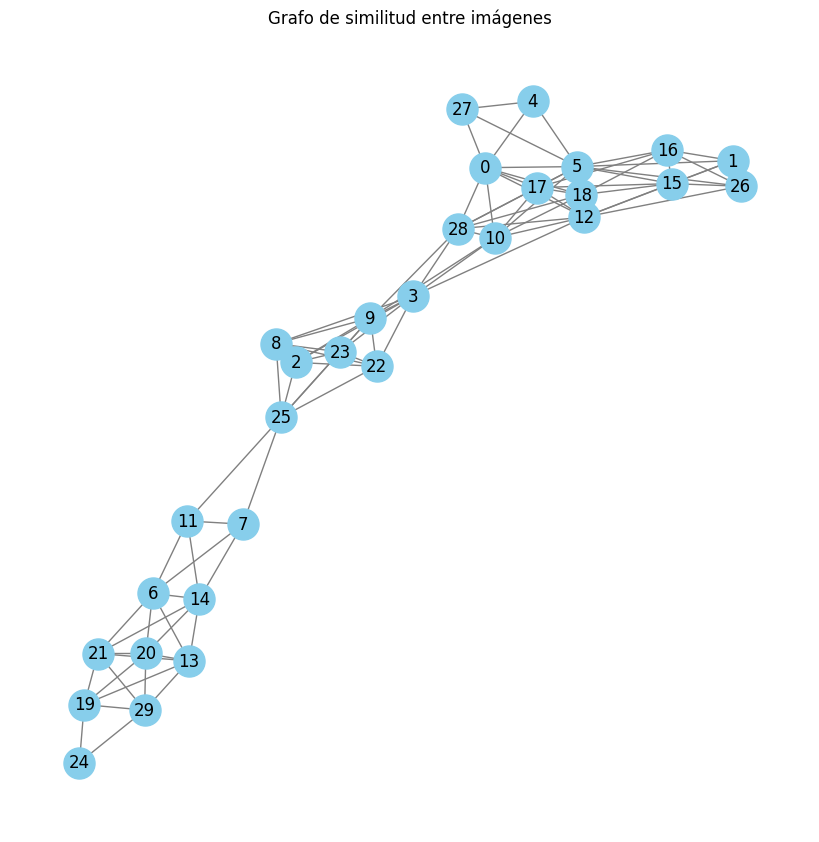

In [51]:
def generate_dataset(n_img=30, size=10):
    images = []
    params = []
    for _ in range(n_img):
        r = 2
        x = np.random.uniform(r, size - r)
        y = np.random.uniform(r, size - r)
        img = generate_image(r, x, y, size)
        images.append(img)
        params.append((r, x, y))
    return images, params


number_images = 30
images, parameters = generate_dataset(n_img=number_images)

def mse(img1, img2):
    return np.mean((img1.astype("float") - img2.astype("float")) ** 2)/255.0**2

X = np.zeros((len(images), len(images)))
for i, j in combinations(range(len(images)), 2):
    X[i, j] = mse(images[i], images[j])
    X[j, i] = X[i, j]


def build_g(imagenes, umbral):
    G = nx.Graph()
    for idx, _ in enumerate(imagenes):
        G.add_node(idx)
    for i, j in combinations(range(len(imagenes)), 2):
        distancia = mse(imagenes[i], imagenes[j])
        if distancia < umbral:
            G.add_edge(i, j)
    return G
def visualize_g(G):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
    plt.title("Grafo de similitud entre imágenes")
    plt.show()

G = build_g(images, umbral=np.percentile(X.reshape(-1), 30))
Y = nx.to_numpy_array(G, dtype=int)
X = (X - np.mean(X.reshape(-1)))/np.var(X.reshape(-1))**0.5 + np.random.randn(X.shape[0], X.shape[1]) 
visualize_g(G)

MSE = 0.10


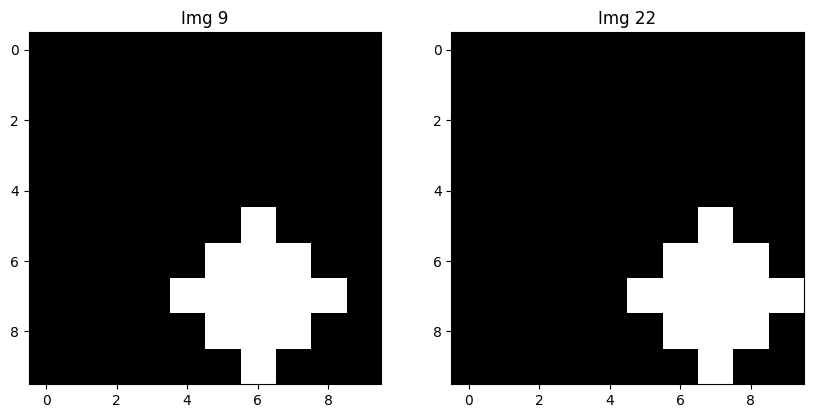

In [53]:
a , b = np.array(G.edges())[np.random.randint(0, len(G.edges()))]
print(f"MSE = {mse(images[a], images[b]):.2f}")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[a], cmap='gray')
plt.title(f"Img {a}")
plt.subplot(1, 2, 2)
plt.imshow(images[b], cmap='gray')
plt.title(f"Img {b}")
plt.show()


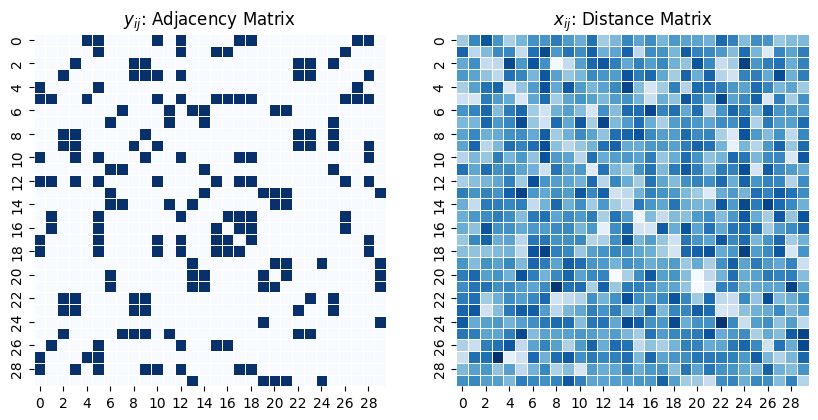

In [54]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title(r"$y_{ij}$: Adjacency Matrix")
plt.subplot(1, 2, 2)
sns.heatmap(X, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title(r"$x_{ij}$: Distance Matrix")

plt.show()

# Latent space

To start the latent space model, the number of nodes $n$ in the graph is calculated and the latent variables are randomly initialized with sampling from a normal standard distribution a matrix of size $n\times 2$ since we are representing our network in a $2$-dimensional space.

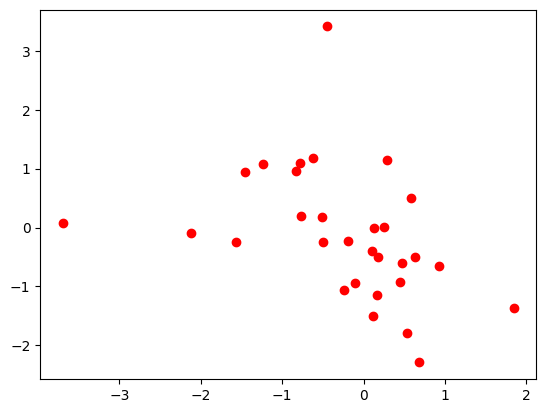

In [55]:
n = len(G.nodes)

Z = np.random.randn(n, 2)
plt.plot(Z[:,0],Z[:,1], 'ro')
plt.show()

In [91]:
def loglikelihood(Z,alpha,beta):
    total = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if i != j:
                d = 0.5 * np.linalg.norm(Z[i] - Z[j])**2
                eta = alpha + beta * X[i, j] - d
                total += eta * Y[i,j]  + np.log(expit(-eta))
    return total 

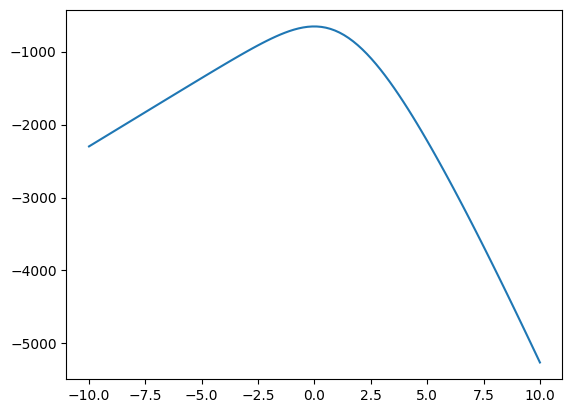

In [92]:
plt.plot(np.linspace(-10,10,100),[loglikelihood(Z,t,0.1) for t in np.linspace(-10,10,100)])
plt.show()

In [76]:
def grad_loglikelihood(Z,alpha,beta):
    grad_Z = np.zeros_like(Z)
    grad_alpha = 0.0
    grad_beta = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                d = 0.5 * np.linalg.norm(Z[i] - Z[j])**2
                eta = alpha + beta * X[i, j] - d
                grad_Z[i,:] +=  (Z[j] - Z[i]) * (Y[i,j] - expit(eta))
                grad_alpha +=  (Y[i,j] - expit(eta))
                grad_beta +=  X[i,j] * (Y[i,j] - expit(eta))
    return grad_Z, grad_alpha, grad_beta

-655.745957636281
-431.5025538329115


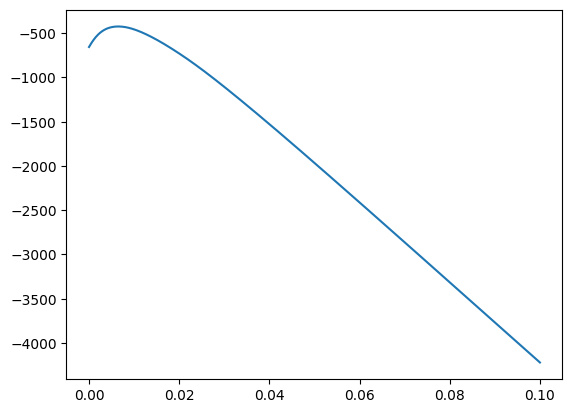

In [93]:
grad_Z,  grad_a, grad_b = grad_loglikelihood(Z,0.1,0.1)
lr = 0.005
print(loglikelihood(Z,0.1,0.1))
print(loglikelihood(Z +lr*grad_Z,0.1+lr*grad_a, 0.1+lr*grad_b))
plt.plot(np.linspace(0.0,0.1,1000),[loglikelihood(Z +lr*grad_Z,0.1+lr*grad_a,0.1+lr*grad_b) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

## Searching MLE

For searching the maximum likelihood estimation, we search the maximum of the loglikelihood function through gradient descent with line search.

In [67]:
def SearchingMLE(Z_init, a_init, b_init, tol=1e-1, max_iter=1000, alpha_init=0.1, rho=0.5, c=1e-4):
    Z0 = Z_init
    historyZ = [Z0]

    a0 = a_init
    historya = [a0]

    b0 = b_init
    historyb = [b0]
    
    for i in range(max_iter):
        grad_Z,  grad_a, grad_b = grad_loglikelihood(Z0,a0,b0)
        if np.linalg.norm(grad_Z) + np.abs(grad_a) + np.abs(grad_b) < tol:
            break  # Convergence criterion
        
        alpha = alpha_init
        
        # Line search using the Armijo condition
        while loglikelihood(Z0 + alpha * grad_Z,a0 + alpha*grad_a, b0 + alpha*grad_b) < loglikelihood(Z0,a0,b0)+ c * alpha * (np.trace(np.transpose(grad_Z) @ Z0) + grad_a * a0 + + grad_b * b0):
            alpha *= rho
            if alpha < 1e-4:
                alpha = 0.0
                break
        
        # Update step
        Z0 = Z0 + alpha * grad_Z  
        a0 = a0 + alpha * grad_a
        b0 = b0 + alpha * grad_b
        
        historyZ.append(Z0)
        historya.append(a0)
        historyb.append(b0)
    
    return  Z0, a0, b0, historyZ, historya, historyb

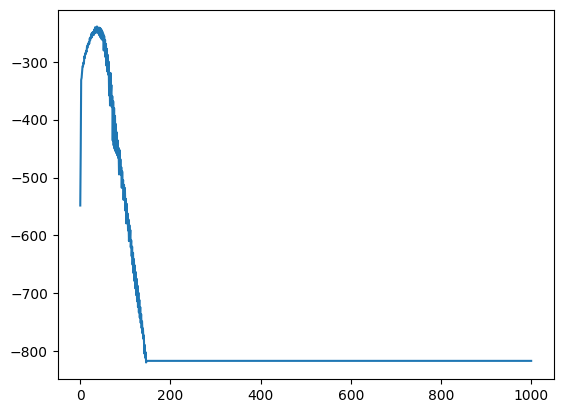

In [58]:
Z0, a0, b0, historyZ, historya, historyb  =  SearchingMLE(np.random.randn(n, 2),np.random.randn(),np.random.randn())
Z0 = Z0 - np.mean(Z0, axis=0)
plt.plot([loglikelihood(historyZ[t],historya[t],historyb[t]) for t in range(len(historya))])
plt.show()

In [94]:
print(loglikelihood(Z0,a0,b0))
print(loglikelihood(np.random.randn(n, 2),np.random.randn(),np.random.randn()))

-113.49784059853182
-1030.360070363489


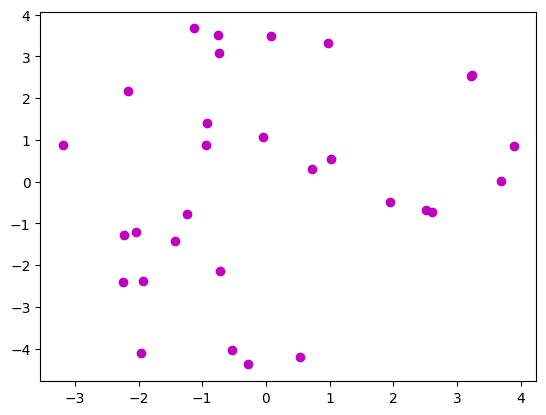

In [88]:
plt.plot(Z0[:,0],Z0[:,1], 'mo')
plt.show()

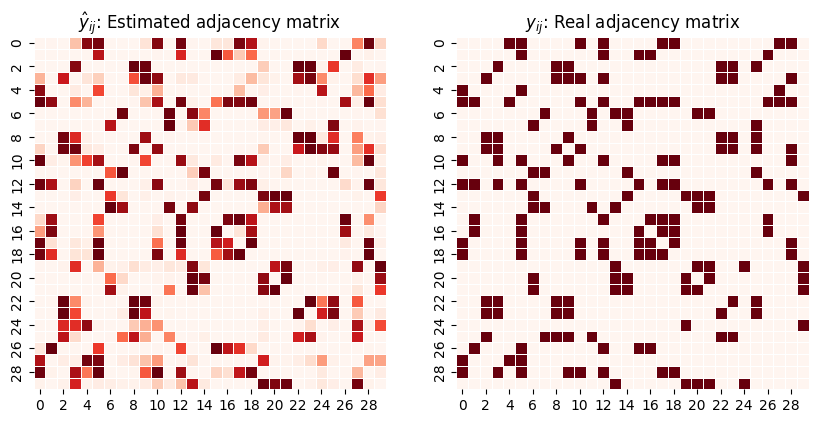

In [89]:
YML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = 0.5 * np.linalg.norm(Z0[i] - Z0[j])**2
            eta = a0 + b0 * X[i, j] - d
            YML[i,j] = expit(eta)
plt.figure(figsize=(10, 5))            
plt.subplot(1, 2, 1)            
sns.heatmap(YML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title(r"$\hat{y}_{ij}$: Estimated adjacency matrix")
plt.subplot(1, 2, 2)
sns.heatmap(Y, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title(r"$y_{ij}$: Real adjacency matrix")
plt.show()

# Prior distribution

-67.73496812613823
-64.17716347075256


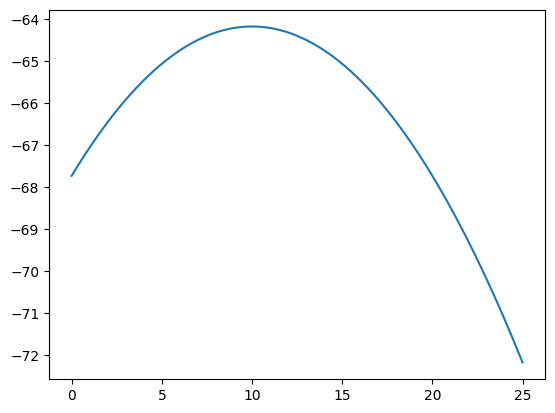

In [90]:
def logpriori(Z,a,b,var=10):
    return (-1) * (np.log((2*np.pi*var)**((n+1)/2)) + 0.5 * np.sum(Z**2)/var + 0.5 * a**2 / var + + 0.5 * b**2 / var)

def grad_logpriori(Z,a,b,var=10):
    grad_Z = np.zeros_like(Z)
    for i in G.nodes():
        grad_Z[i,:] = (-1) * Z[i,:] / var
    grad_a = (-1) * a / var 
    grad_b = (-1) * b / var  
    return grad_Z, grad_a, grad_b

grad_Z,  grad_a, grad_b= grad_logpriori(Z,0.1,0.1)
lr = 10
print(logpriori(Z,0.1,0.1))
print(logpriori(Z +lr*grad_Z,0.1+lr*grad_a, 0.1+lr*grad_b))
plt.plot(np.linspace(0.0,25.0,1000),[logpriori(Z +lr*grad_Z,0.1+lr*grad_a,0.1+lr*grad_b) for lr in np.linspace(0.0,25.0,1000)])
plt.show()

# Potential energy

723.4809257624192
499.188767620401


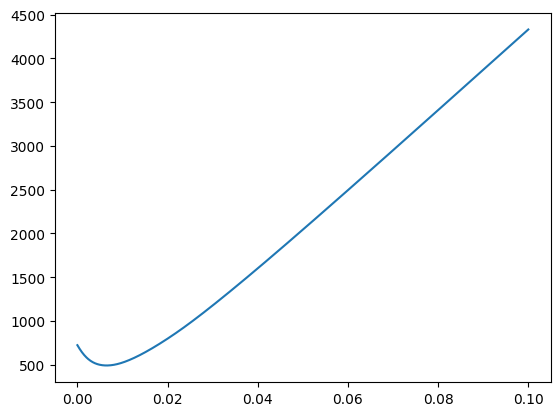

In [96]:
def U(Z,a,b,var=10):
    return (-1) * (loglikelihood(Z,a,b) + logpriori(Z,a,b,var))

def grad_U(Z,a,b,var=100):
    grad_Z_likelihood, grad_a_likelihood, grad_b_likelihood = grad_loglikelihood(Z,a,b)
    grad_Z_priori, grad_a_priori, grad_b_priori = grad_logpriori(Z,a,b,var)
    grad_Z = grad_Z_likelihood + grad_Z_priori
    grad_a = grad_a_likelihood + grad_a_priori
    grad_b = grad_b_likelihood + grad_b_priori
    return -grad_Z, -grad_a, -grad_b

grad_Z,  grad_a, grad_b = grad_U(Z,0.1,0.1)
lr = 0.005
print(U(Z,0.1,0.1))
print(U(Z - lr*grad_Z,0.1 - lr*grad_a, 0.1 - lr*grad_b))
plt.plot(np.linspace(0.0,0.1,1000),[U(Z -lr*grad_Z,0.1-lr*grad_a,0.1 - lr*grad_b) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

## Applying Hamiltonian Monte Carlo Algorithm

In [100]:
def compute_Z_star(Z, Z0):
    """ Computes Z* = Z0 Z^T (Z Z0^T Z0 Z^T)^(-1/2) Z using SVD """
    A = Z @ Z0.T @ Z0 @ Z.T  # Compute A = Z Z0^T Z0 Z^T
    
    # Compute A^(-1/2) using SVD
    U, S, _ = np.linalg.svd(A)
    S_inv_sqrt = np.diag(1.0 / np.sqrt(S))
    A_inv_sqrt = U @ S_inv_sqrt @ U.T
    Z_star =  Z0 @ Z.T @ A_inv_sqrt @ Z
    # Compute Z*
    return Z_star - np.mean(Z_star, axis=0)

In [149]:
def hmc(params, num_samples, epsilon=0.05, L=3, std_dev=1.0):

    Z_init, a_init, b_init = params
    samples_Z = [Z_init]
    samples_a = [a_init]
    samples_b = [b_init]

    Hamiltonian_p = [U(Z_init,a_init,b_init)]

    Z = Z_init.copy()
    a = a_init.copy()
    b = b_init.copy()

    aceptance_rate = 0.0
    
    for _ in tqdm(range(num_samples)):

        grad_Z,  grad_a, grad_b = grad_U(samples_Z[-1],samples_a[-1], samples_b[-1])


        ### HMC algorithm for Z
        for i in range(Z.shape[0]):
            grad_Z_i = grad_Z[i].copy()
            Z_i = Z[i].copy()
            
            p_i = np.random.normal(0, std_dev, size=Z_i.shape)
            current_p = p_i.copy()
            #Leapfrog integration
            p_i -= epsilon * grad_Z_i / 2        
            for _ in range(L):
                Z_i += epsilon * p_i
                Z[i] = Z_i
                grad_Z,  _, _ = grad_U(Z,samples_a[-1],samples_b[-1])
                grad_Z_i = grad_Z[i].copy()
                p_i -= epsilon * grad_Z_i
            p_i -= epsilon * grad_Z_i / 2
            p_i = -p_i  # Negate momentum to make the proposal symmetric
            # Hamiltonian
            current_U = U(samples_Z[-1],samples_a[-1],samples_b[-1])
            current_K = 0.5 * np.sum(current_p**2)
            current_H = current_U + current_K
            proposed_U = U(Z,samples_a[-1],samples_b[-1])
            proposed_K = 0.5 * np.sum(p_i**2)
            proposed_H = proposed_U + proposed_K
            # Metropolis-Hastings acceptance rate
            log_accept_ratio = current_H - proposed_H

            samples_a.append(samples_a[-1])
            samples_b.append(samples_b[-1])

            if np.log(np.random.rand()) < log_accept_ratio:
                Z_C = compute_Z_star(Z, Z0)
                samples_Z.append(Z_C.copy())
                aceptance_rate += 1.0
                Hamiltonian_p.append(proposed_H)
            else:
                samples_Z.append(samples_Z[-1])
                Hamiltonian_p.append(current_H)
                

            grad_Z,  grad_a, grad_b = grad_U(samples_Z[-1],samples_a[-1], samples_b[-1])

        

        ### HMC algorithm for a
        grad_Z,  grad_a, grad_b = grad_U(samples_Z[-1],samples_a[-1], samples_b[-1])
        p = np.random.normal(0, std_dev, size=1)
        current_p = p.copy()
        #Leapfrog integration
        p -= epsilon * grad_a / 2        
        for _ in range(L):
            a += epsilon * p
            _,  grad_a , _ = grad_U(samples_Z[-1],a,samples_b[-1])
            p -= epsilon * grad_a
        p -= epsilon * grad_a / 2
        p = -p  # Negate momentum to make the proposal symmetric
        # Hamiltonian
        current_U = U(samples_Z[-1],samples_a[-1],samples_b[-1])
        current_K = 0.5 * np.sum(current_p**2)
        current_H = current_U + current_K

        proposed_U = U(samples_Z[-1],a,samples_b[-1])
        proposed_K = 0.5 * np.sum(p**2)
        proposed_H = proposed_U + proposed_K
        
        # Metropolis-Hastings acceptance rate
        log_accept_ratio = current_H - proposed_H

        samples_Z.append(samples_Z[-1])
        samples_b.append(samples_b[-1])

        if np.log(np.random.rand()) < log_accept_ratio:
            samples_a.append(a.copy())
            aceptance_rate += 1.0
            Hamiltonian_p.append(proposed_H)
        else:
            samples_a.append(samples_a[-1])
            Hamiltonian_p.append(current_H)



        ### HMC algorithm for b
        grad_Z,  grad_a, grad_b = grad_U(samples_Z[-1],samples_a[-1], samples_b[-1])
        p = np.random.normal(0, std_dev, size=1)
        current_p = p.copy()
        #Leapfrog integration
        p -= epsilon * grad_b / 2        
        for _ in range(L):
            b += epsilon * p
            _,  _ , grad_b = grad_U(samples_Z[-1],samples_a[-1],b)
            p -= epsilon * grad_b
        p -= epsilon * grad_b / 2
        p = -p  # Negate momentum to make the proposal symmetric
        # Hamiltonian
        current_U = U(samples_Z[-1],samples_a[-1],samples_b[-1])
        current_K = 0.5 * np.sum(current_p**2)
        current_H = current_U + current_K

        proposed_U = U(samples_Z[-1],samples_a[-1],b)
        proposed_K = 0.5 * np.sum(p**2)
        proposed_H = proposed_U + proposed_K
        
        # Metropolis-Hastings acceptance rate
        log_accept_ratio = current_H - proposed_H

        samples_Z.append(samples_Z[-1])
        samples_a.append(samples_a[-1])

        if np.log(np.random.rand()) < log_accept_ratio:
            samples_b.append(b.copy())
            aceptance_rate += 1.0
            Hamiltonian_p.append(proposed_H)
        else:
            samples_b.append(samples_b[-1])
            Hamiltonian_p.append(current_H)
            

    aceptance_rate /= num_samples * (Z.shape[0] + 2)
    print(f"Acceptance rate: {aceptance_rate:.5f}")
    samples_Z = np.array(samples_Z)
    samples_a = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in samples_a]
    samples_b = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in samples_b]
    Hamiltonian_p = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in Hamiltonian_p]
    return samples_Z, samples_a, samples_b, Hamiltonian_p

In [159]:
#Perturbation of the ML parameters
Z1 = Z0 + np.random.randn(n, 2) * 1
a1 = a0 + np.random.randn() * 1
b1 = b0 + np.random.randn() * 1
print(f" The log-likelihood of the new parameters is {loglikelihood(Z1,a1,b1)} and the log-likelihood of the ML parameters is {loglikelihood(Z0,a0,b0)}")

# Run HMC to sample from the posterior distribution
samples_Z, samples_a, samples_b, Hp = hmc((Z1,a1,b1), num_samples=50, epsilon=0.05, L=20, std_dev=2.0)

# Estimators of Bayesian inference
## CM: Conditioned mean
Z_CM =  np.mean(samples_Z, axis=0)
a_CM = np.mean(samples_a, axis=0)
b_CM = np.mean(samples_b, axis=0)
## MAP: Maximum a posteriori
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]
b_MAP = samples_b[np.argmin(Hp)]

print(f"""The log-likelihood of the CM parameters is {loglikelihood(Z_CM,a_CM,b_CM)}
The log-likelihood of the MAP parameters is {loglikelihood(Z_MAP,a_MAP,b_MAP)}
The log-likelihood of the ML parameters is {loglikelihood(Z0,a0,b0)}""")


 The log-likelihood of the new parameters is -442.72217247421565 and the log-likelihood of the ML parameters is -113.49784059853182


100%|██████████| 50/50 [17:33<00:00, 21.07s/it]

Acceptance rate: 0.04437
The log-likelihood of the CM parameters is -120.31311560153888
The log-likelihood of the MAP parameters is -119.25620961249156
The log-likelihood of the ML parameters is -113.49784059853182


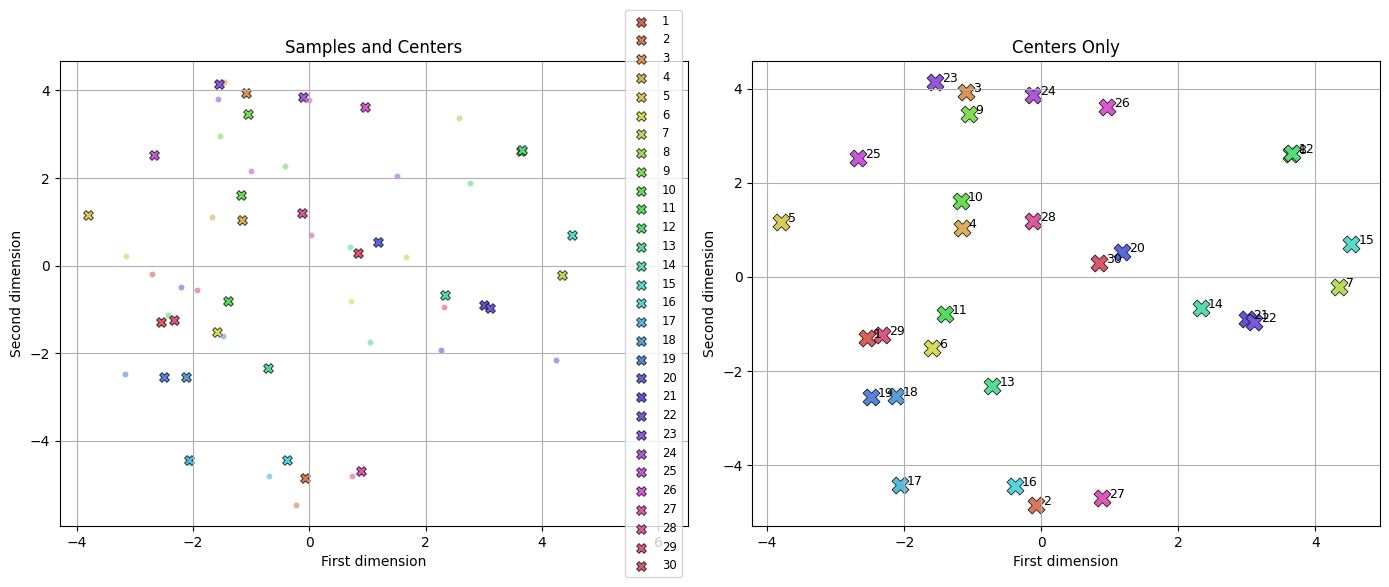

In [169]:
def plot_Z_samples(samples_Z):
    samples_Z = np.array(samples_Z)  
    num_points = samples_Z.shape[1]  
    palette = sns.color_palette("hls", num_points)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    centers = [] 

    for i in range(num_points):
        trace = samples_Z[:, i, :]
        mean_point = trace.mean(axis=0)
        centers.append(mean_point)
        sns.scatterplot(
            ax=axes[0],
            x=trace[:, 0],
            y=trace[:, 1],
            color=palette[i],
            alpha=0.6,
            s=20
        )

        sns.scatterplot(
            ax=axes[0],
            x=[mean_point[0]],
            y=[mean_point[1]],
            color=palette[i],
            marker='X',
            s=50,
            edgecolor='black',
            linewidth=0.5,
            label=f"{i+1}"
        )

        axes[1].scatter(
            mean_point[0],
            mean_point[1],
            color=palette[i],
            s=150,
            marker='X',
            edgecolor='black',
            linewidth=0.5
        )
        axes[1].text(
            mean_point[0] + 0.1,
            mean_point[1] + 0.001,
            f"{i+1}",
            fontsize=9
        )

    axes[0].set_title("Samples and Centers")
    axes[0].set_xlabel("First dimension")
    axes[0].set_ylabel("Second dimension")
    axes[0].legend(loc="right", fontsize="small")
    axes[0].grid(True)

    axes[1].set_title("Centers Only")
    axes[1].set_xlabel("First dimension")
    axes[1].set_ylabel("Second dimension")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_Z_samples(samples_Z)

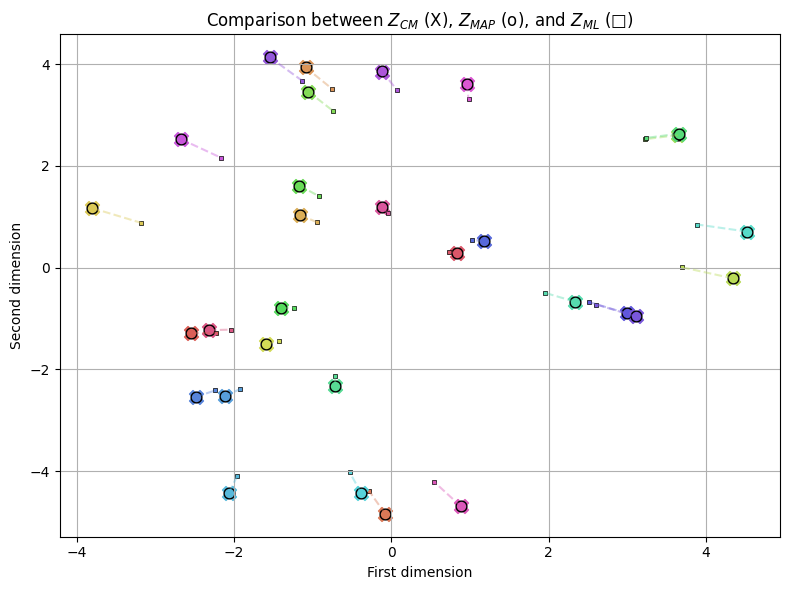

In [161]:
palette = sns.color_palette("hls", n)
plt.figure(figsize=(8, 6))
for i in range(n):
    x_cm, y_cm = Z_CM[i]
    x_map, y_map = Z_MAP[i]
    x_ml, y_ml = Z0[i]
    plt.scatter(x_cm, y_cm, color=palette[i], marker='X', s=100, label=f"{i+1} (CM)")
    plt.scatter(x_map, y_map, color=palette[i], marker='o', s=60, edgecolor='black', label=f"{i+1} (MAP)")
    plt.scatter(x_ml, y_ml, color=palette[i], marker='s', s=10, edgecolor='black', linewidth=0.5, label=f"{i+1} (ML)")

    plt.plot([x_cm, x_map], [y_cm, y_map], color=palette[i], linestyle='--', alpha=0.4)
    plt.plot([x_map, x_ml], [y_map, y_ml], color=palette[i], linestyle='--', alpha=0.4)
plt.xlabel("First dimension")
plt.ylabel("Second dimension")
plt.title("Comparison between $Z_{CM}$ (X), $Z_{MAP}$ (o), and $Z_{ML}$ (□)")
plt.grid(True)
plt.tight_layout()
plt.show()

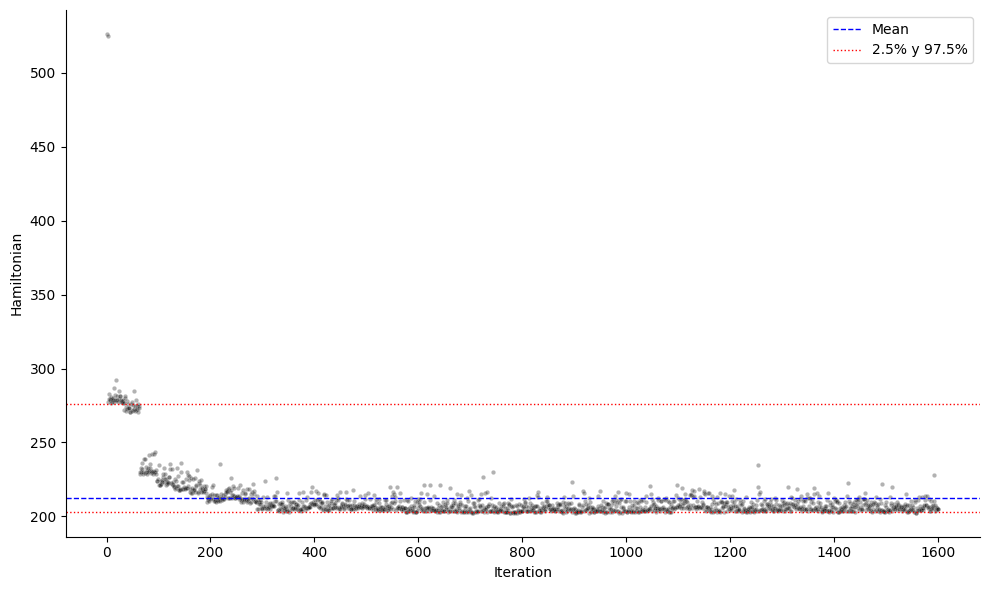

In [162]:
x = Hp
iterations = np.arange(1, len(x) + 1)

data = pd.DataFrame({
    'Iteration': iterations,
    'LogLikelihood': x
})

mean_x = np.mean(x)
quantiles_x = np.quantile(x, [0.025, 0.975])

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Iteration', y='LogLikelihood', data=data, color='black', alpha=0.3, s=10)

plt.axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')


plt.axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
plt.axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)


plt.xlabel("Iteration")
plt.ylabel("Hamiltonian")
plt.title("")
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

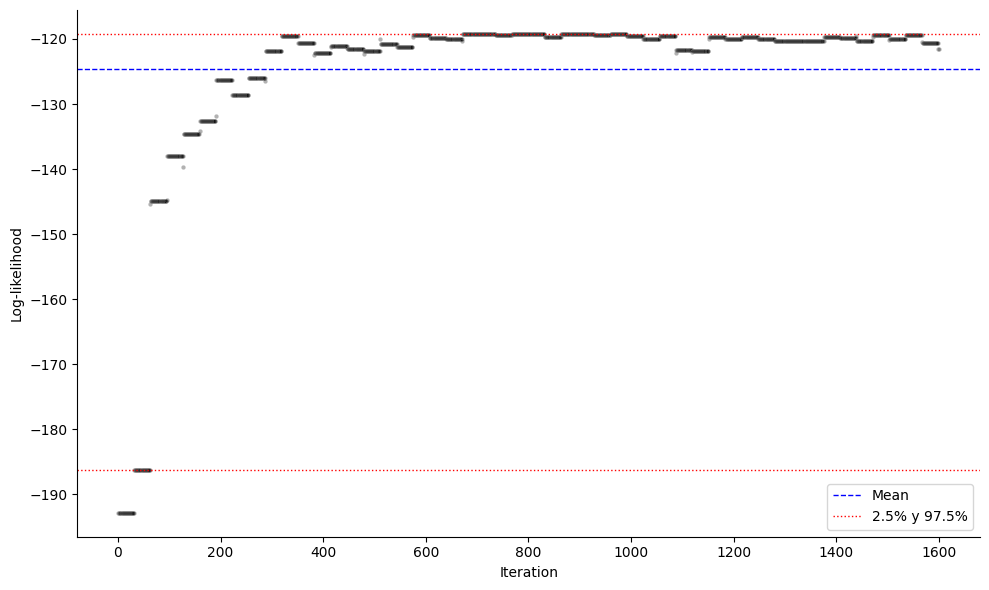

In [163]:
x = [np.float64(loglikelihood(samples_Z[i],samples_a[i],samples_b[i]))for i in range(1,len(samples_a))]
iterations = np.arange(1, len(x) + 1)

data = pd.DataFrame({
    'Iteration': iterations,
    'LogLikelihood': x
})
mean_x = np.mean(x)
quantiles_x = np.quantile(x, [0.025, 0.975])
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Iteration', y='LogLikelihood', data=data, color='black', alpha=0.3, s=10)
plt.axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
plt.axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
plt.axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.title("")
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

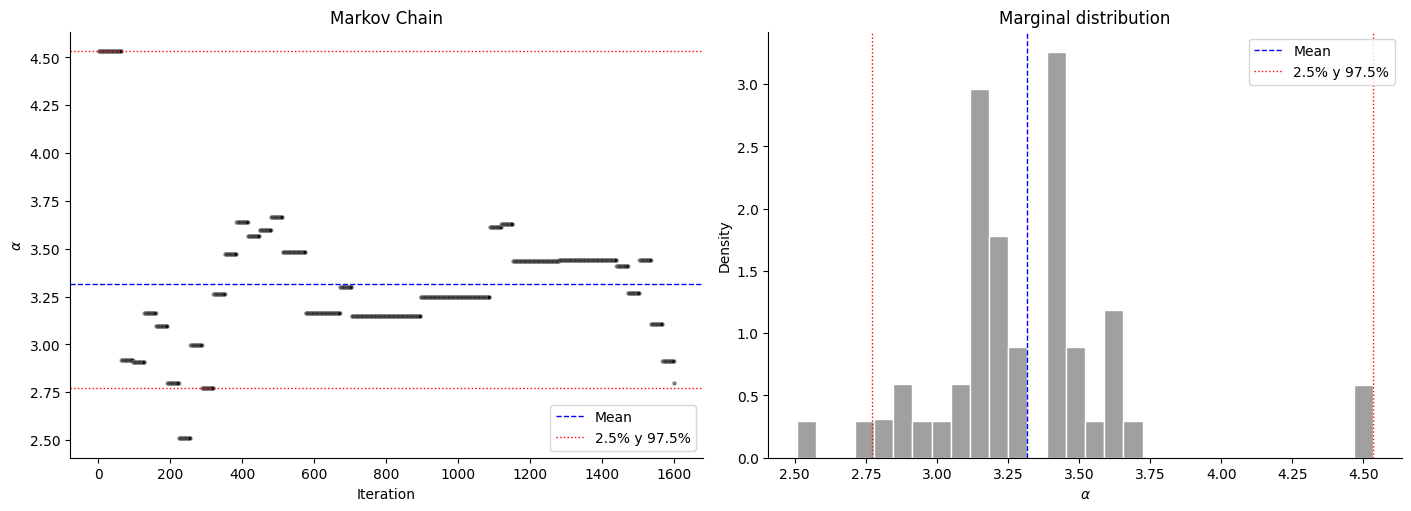

In [164]:
x = samples_a
iterations = np.arange(1, len(x) + 1)

mean_x = np.mean(x)
quantiles_x = np.quantile(x, [0.025, 0.975])

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel(r"$\alpha$")
axes[0].set_title("Markov Chain")
axes[0].legend()
sns.despine(ax=axes[0])

sns.histplot(x, bins=30, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[1].set_xlabel(r"$\alpha$")
axes[1].set_ylabel("Density")
axes[1].set_title("Marginal distribution")
axes[1].legend()
sns.despine(ax=axes[1])

plt.show()

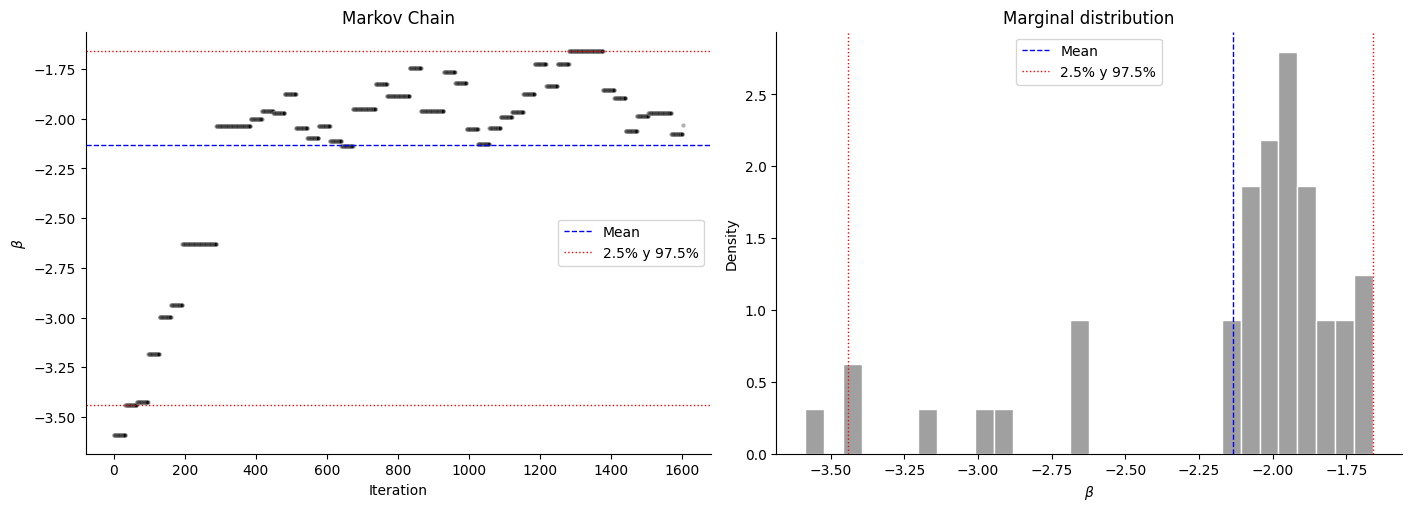

In [165]:
x = samples_b
iterations = np.arange(1, len(x) + 1)

mean_x = np.mean(x)
quantiles_x = np.quantile(x, [0.025, 0.975])

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel(r"$\beta$")
axes[0].set_title("Markov Chain")
axes[0].legend()
sns.despine(ax=axes[0])

sns.histplot(x, bins=30, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[1].set_xlabel(r"$\beta$")
axes[1].set_ylabel("Density")
axes[1].set_title("Marginal distribution")
axes[1].legend()
sns.despine(ax=axes[1])

plt.show()